In [151]:
# imports

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
import numpy as np
import sympy as sp
import pandas as pd

In [152]:
plt.style.use(["bmh"])
np.set_printoptions(threshold=np.inf, precision=4, suppress=False)

In [153]:
# functions

def make_Ki_vector(N, ko, kp, ka, sigma=0):
    "make vector Ko, Kp, Ka of each node"
    "Parameters: sigma = random number"
    Ko = np.random.normal(ko, sigma, N)
    Kp = np.random.normal(kp, sigma, N)
    Ka = np.random.normal(ka, sigma, N)

    return Ko, Kp, Ka

def make_K_matrix(Ko, Kp, Ka):
    "make stiffness matrix for torsional spring"
    N = np.shape(Ko)[0]
    K = np.zeros((N, N), dtype=float)

    for i in range(N):
        K[i, (i - 1) % N] = Kp[(i - 1) % N] + Ka[(i - 1) % N]
        K[i, i] = Ko[i]
        K[i, (i + 1) % N] = Kp[i % N] - Ka[i % N]

    return K

def find_equilibrium(K, D, fixed_nodes, N):
    def loop_equation(i, N, type):
        polytheta = np.pi - (N - 2) * np.pi / N
        sum_theta = [
            sp.Add(*[val + polytheta for val in D_sym[1 : j + 2]]) for j in range(i, N)
        ]
        sum_theta = list(
            dict.fromkeys(sum_theta)
        )  # Remove any potential duplicates from sum_theta
        if type == "sin":
            loop = [sp.sin(val) for val in sum_theta]
        else:
            loop = [sp.cos(val) for val in sum_theta]
        loop_final = sum(loop)
        return loop_final

    def solve():
        tolerance = 1e-6
        max_attempts = 5  # Maximum number of attempts to decrease tolerance
        attempt = 0

        while attempt < max_attempts:
            try:
                solutions = sp.nsolve(equations, variables, guess, tol=tolerance)
                break  # If successful, break out of the loop
            except ValueError as e:
                if "Could not find root within given tolerance" in str(e):
                    # Double the precision by halving the tolerance
                    tolerance *= 10
                    attempt += 1
                    print(f"tolerance decrease since solution could not find. Attempt: {attempt}")
                else:
                    raise  # If the error is not related to tolerance, raise it
        else:
            # This block will run if the loop completes without finding a solution
            raise ValueError(
                "Could not find a solution even after decreasing tolerance."
            )
        return solutions

    L = 1  # lengthS
    nodes = np.arange(0, N)
    fixed_nodes = np.sort(fixed_nodes)  # fixed nodes
    nodes = np.delete(nodes, fixed_nodes)  # free nodes

    D_sym = sp.symbols("D0:%d" % N)  # create D_0 ... D_N
    K_sym = sp.Matrix(K)

    "Lagrange multiplier"
    a = sp.symbols("a0:%d" % len(fixed_nodes))  # fixed angle
    b = sp.symbols("b")  # sum of angles
    c = sp.symbols("c")  # x_0 == 0
    d = sp.symbols("d")  # y_0 == 0

    equations = []
    j = 0  # fixed node id

    for i in range(N):
        equation = K_sym.row(i).dot(D_sym) + b  # Common part

        if i != 0:  # for i!=0 node, add constraint (x0, y0)==0
            equation -= c * L * loop_equation(i - 1, N, type="sin")
            equation += d * L * loop_equation(i - 1, N, type="cos")

        if i in fixed_nodes:  # for fixed node, add constrain D[i] = constant
            equation += a[j]
            j += 1

        equations.append(sp.Eq(equation, 0))

    for _, fi in enumerate(fixed_nodes):
        equations.append(sp.Eq(D_sym[fi], D[fi]))
    equations.append(sp.Eq(sp.Add(*D_sym), 0))
    equations.append(sp.Eq(L + L * loop_equation(0, N, type="cos"), 0))
    equations.append(sp.Eq(L * loop_equation(0, N, type="sin"), 0))

    multiplier_guess = [0.0] * (len(fixed_nodes) + 3)
    De_guess = [0.1] * N
    guess = De_guess + multiplier_guess
    variables = list(D_sym) + list(a) + [b] + [c] + [d]
    solutions = solve()

    De = [solutions[i] for i in range(N)]
    De = [
        float(val) for val in De
    ]  # Convert SymPy Float objects to native Python floats
    multiplier = solutions[:-4]

    "convert list to numpy array"
    De = np.array(De)
    multiplier = np.array(multiplier)
    return De

def update_k(K, Ko, Kp, Ka, kodot, kpdot, kadot):
    N = np.shape(K)[0]
    for i in range(N):
        Ko[i] += kodot[i]
        Kp[i] += kpdot[i]
        Ka[i] += kadot[i]
    K = make_K_matrix(Ko, Kp, Ka)

    return K, Ko, Kp, Ka

def append_target_df(df_name, DI_id, DI_val, DT_id, DT_val):

    df_name.loc[len(df_name)] = [DI_id, DI_val, DT_id, DT_val]

    return df_name


def new_target_df():

    df_name = pd.DataFrame(columns=['Input ID', 'Input value', 'Target ID', 'Target value'])
    return df_name


def convert_Dval(D_val_all, D_id_all, target_id, N):
    D = np.zeros((1, N))
    D[:, D_id_all[target_id]] = D_val_all[target_id]
    return D.reshape(
        N,
    )

In [154]:
# function with the stability constraints
def make_kdot(K, Ko, Kp, Ka, DF, DC, lr, direction):
    N = np.shape(DF)[0]
    I = np.zeros_like(K)
    np.fill_diagonal(I, 1)
    Ir = np.roll(I, -1, axis=0)
    Il = np.roll(I, 1, axis=0)

    "rotation of free state"
    DFil = np.dot(Il, DF)  # DF[i-1]
    DFi = np.dot(I, DF)  # DF[i]
    DFir = np.dot(Ir, DF)  # DF[i+1]
    "clamped rotation"
    DCil = np.dot(Il, DC)  # DC[i-1]
    DCi = np.dot(I, DC)  # DC[i]
    DCir = np.dot(Ir, DC)  # DC[i+1]

    grad_ko = (np.square(DFi) - np.square(DCi)) * 0.5
    grad_kp = DFi * DFir - DCi * DCir
    grad_ka = -(DFi * DFir - DCi * DCir) * direction

    kodot = lr * grad_ko
    kpdot = lr * grad_kp
    kadot = lr * grad_ka

    def stability_constraint(Ko, Kp, Ka):
        for i in range(N):
            # the updated parameters
            Ko_ = Ko[i] + kodot[i]
            Kp_ = Kp[i] + kpdot[i]
            Ka_ = Ka[i] + kadot[i]
            Ki = Ko_
            Kil = Kp_ + Ka_
            kir = Kp_ - Ka_

            # Gershgorin disk
            Ci = Ki  # the center of ith disk
            Ri = abs(Kil) + abs(kir)  # the radius of ith disk
            Stable = (
                Ci > 0 and (Ri - Ci) < 0
            )  # if yield, the real part of ith eigenvalue is positive

            if not Stable:
                # kodot[i] = 0
                # kpdot[i] = 0
                kadot[i] = 0

    stability_constraint(Ko, Kp, Ka)

    return kodot, kpdot, kadot

In [155]:
#simulation

# initials
def Simulation(N, Nsteps, Koi, Kpi, Kai, lr, target_df):
    Ntarget = np.shape(target_df['Input ID'])[0]
    print(f'System size: {N}')
    print(f'Number of targets: {Ntarget}')
    print(target_df)
    K_step = np.zeros((N, N, Nsteps + 1))  # the stiffness materix of each steps
    Ko_step = np.zeros((Nsteps + 1, N))
    Kp_step = np.zeros((Nsteps + 1, N))
    Ka_step = np.zeros((Nsteps + 1, N))
    DF_step = np.zeros(
        (Nsteps + 1, N, Ntarget)
    )  # the angle deflecton of the free state in each step
    eigvals_step = np.zeros(
        (Nsteps + 1, N), dtype=np.complex64
    )  # eigenvalues of stiffness matrix in each steps
    Error_step = np.zeros((Nsteps, Ntarget))

    Ko, Kp, Ka = make_Ki_vector(N, Koi, Kpi, Kai, sigma=0)
    K = make_K_matrix(Ko, Kp, Ka)
    # print("Stiffness Matrix K = \n", K)

    "initial values"
    K_step[:, :, 0] = K
    Ko_step[0, :] = Ko
    Kp_step[0, :] = Kp
    Ka_step[0, :] = Ka
    eigvals_step[0, :] = np.sort(np.linalg.eigvals(K))

    Errors_20step  = np.zeros((1, Ntarget))
    Errors_10step = np.zeros((1, Ntarget))

    #----------------------------------------------------------------------------
    #                              simulation loop
    #----------------------------------------------------------------------------

    for i in range(Ntarget):
        DF_step[0, :, i] = convert_Dval(target_df['Input value'], target_df['Input ID'], i, N)
    Error = 0
    for step in range(Nsteps):
        try:
            if (step + 1) % 10 == 0:
                print("Current step: {} / {}".format(step + 1, Nsteps))
            for target in range(Ntarget):

                if (step + 1) % 10 == 0:
                    print(f'Error {target + 1}: {Error}')
                    
                DI = convert_Dval(target_df['Input value'], target_df['Input ID'], target, N)
                DT = convert_Dval(target_df['Target value'], target_df['Target ID'], target, N)

                nodesI = target_df.iloc[target]['Input ID']
                nodesT = target_df.iloc[target]['Target ID']
                d = np.sign(max(nodesI) - min(nodesT))

                "nodes fixed in clamped state"
                nodesC = np.sort(np.concatenate((nodesI, nodesT)))

                "find initial free states"
                DF = find_equilibrium(K, DI, nodesI, N) #----------
                DF_step[step + 1, :, target] = DF

                " calculate the error"
                Error = np.sum((DF[nodesT] - DT[nodesT]) ** 2)
                Error_step[step, target] = Error

                if step + 1 == (Nsteps):
                    Errors_20step[0, target] = Error_step[step, target]

                if step + 1 == 10:
                    Errors_10step[0, target] = Error_step[step, target]

                "define nudge rotation vector DN"
                DN = np.copy(DI)
                DN[nodesT] = DF[nodesT] + 1 * (DT[nodesT] - DF[nodesT]) # 1 = eta

                "clamped state"
                DC = find_equilibrium(K, DN, nodesC, N)

                "update stiffness matrix"
                kodot, kpdot, kadot = make_kdot(
                    K, Ko, Kp, Ka, DF, DC, lr, direction=d
                )  # --------------------------------
                (
                    K,
                    Ko,
                    Kp,
                    Ka,
                ) = update_k(K, Ko, Kp, Ka, kodot, kpdot, kadot)

            K_step[:, :, step + 1] = K
            Ko_step[step + 1, :] = Ko
            Kp_step[step + 1, :] = Kp
            Ka_step[step + 1, :] = Ka
            eigvals_step[step + 1, :] = np.sort(np.linalg.eigvals(K))

        except ValueError:
            Errors_10step[0, target] = "NaN"
            Errors_20step[0, target] = "NaN"
            print('')
            print("Simulation terminated: No stable solutions could be found.")
            print('')
            break

    np.save("./K_step.npy", K_step)
    np.save("./Ko_step.npy", Ko_step)
    np.save("./Kp_step.npy", Kp_step)
    np.save("./Ka_step.npy", Ka_step)
    np.save("./DF_step.npy", DF_step)
    np.save("./Error_step.npy", Error_step)

    print("Final Stiffness Matrix K = \n", K)
    print(" ")
    # print("Onsite Passive Stiffness Matrix K = \n", Ko)
    # print("Symmetric Passive Stiffness Matrix K = \n", Kp)
    # print("Active Stiffness Matrix K = \n", Ka)
    # print("Eigenvalues = \n", eigvals_step[-1, :])

    # return Ntarget, Error_step, DF_step, Ko_step, Kp_step, Ka_step, eigvals_step
    return Ntarget, Errors_10step, Errors_20step

In [156]:
def Generate_targets(system_size, number_of_targets):

    # empty dataframe for the targets
    targets = new_target_df()
    
    for _ in range(number_of_targets): 

        # angles: between -60 and 60 deg
        DI_id = np.array([np.random.randint(1, (system_size-1)) - 1])  
        DI_val = np.array([(np.random.random() * 120) - 60]) * (np.pi / 180)
        DT_id = np.array([np.random.randint(1, (system_size-1)) - 1])  
        DT_val = np.array([(np.random.random() * 120) - 60]) * (np.pi / 180)

        while DI_id == DT_id:
            DT_id = np.array([np.random.randint(1, (system_size-1)) - 1]) 

        append_target_df(targets, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    return targets

In [157]:
Nsets = 5
Nsystemlist = [6, 7, 8, 9, 10, 11, 12]
Ntargetslist = [1, 2, 3, 4, 5, 6, 7, 8]

data = pd.DataFrame(columns=['System size', 'Number of targets', 'Error (10 steps)', 'Error (20 steps)'])

for N_targets in Ntargetslist:

    for N_system in Nsystemlist:

        for set in range(1, Nsets + 1):

            print(f'Set: {set}')
            print(' ')

            targets = Generate_targets(N_system, N_targets)
            _, Errors_10, Errors_20 = Simulation(N=N_system, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets)

            if np.shape(Errors_10)[1] == 1:
                Error_10 = Errors_10[0,0]
                Error_20 = Errors_20[0,0]
            else:
                Error_10 = np.average(Errors_10, axis=1)[0]
                Error_20 = np.average(Errors_20, axis=1)[0]

            data.loc[len(data)] = [N_system, N_targets, Error_10, Error_20]

print('Finished!')
print(data)

Set: 1
 
System size: 6
Number of targets: 1
  Input ID             Input value Target ID           Target value
0      [0]  [-0.06107006648288908]       [1]  [-0.5840928889717525]
Current step: 10 / 20
Error 1: 0.40128588885781247
Current step: 20 / 20
Error 1: 0.4406693491047316
Final Stiffness Matrix K = 
 [[0.05   0.01   0.     0.     0.     0.0121]
 [0.0069 0.0432 0.016  0.     0.     0.    ]
 [0.     0.041  0.0373 0.0144 0.     0.    ]
 [0.     0.     0.0347 0.0457 0.01   0.    ]
 [0.     0.     0.     0.0045 0.0492 0.01  ]
 [0.01   0.     0.     0.     0.017  0.0455]]
 
Set: 2
 
System size: 6
Number of targets: 1
  Input ID             Input value Target ID           Target value
0      [2]  [-0.20013690693261404]       [0]  [0.47519435585612646]
Current step: 10 / 20
Error 1: 0.24701725290494678
Current step: 20 / 20
Error 1: 0.2514084148750719
Final Stiffness Matrix K = 
 [[0.0455 0.0162 0.     0.     0.     0.01  ]
 [0.01   0.0498 0.0051 0.     0.     0.    ]
 [0.     0.01  

In [158]:
data

,System size,Number of targets,Error (10 steps),Error (20 steps)
0,6.0,1.0,0.402964,0.455911
1,6.0,1.0,0.247403,0.251927
2,6.0,1.0,0.219905,0.000126
3,6.0,1.0,0.076877,0.033750
4,6.0,1.0,0.224671,0.000016
...,...,...,...,...
275,12.0,8.0,0.157730,0.113665
276,12.0,8.0,NaN,NaN
277,12.0,8.0,NaN,NaN
278,12.0,8.0,NaN,NaN


In [159]:
data_accepted = pd.DataFrame(columns=['System size', 'Number of targets', 'Error (10 steps)', 'Error (20 steps)'])
data_rejected = pd.DataFrame(columns=['System size', 'Number of targets'])

checkfornan = data.isnull()
print(checkfornan)

for i in range(len(data)):

    if checkfornan.iat[i, 3] == False:
        data_accepted.loc[len(data_accepted)] = [data.iat[i, 0], data.iat[i, 1], data.iat[i, 2], data.iat[i, 3]]

    elif checkfornan.iat[i, 3]== True:
        data_rejected.loc[len(data_rejected)] = [data.iat[i, 0], data.iat[i, 1]]

print(data_accepted)
print(data_rejected)

     System size  Number of targets  Error (10 steps)  Error (20 steps)
0          False              False             False             False
1          False              False             False             False
2          False              False             False             False
3          False              False             False             False
4          False              False             False             False
..           ...                ...               ...               ...
275        False              False             False             False
276        False              False              True              True
277        False              False              True              True
278        False              False              True              True
279        False              False             False             False

[280 rows x 4 columns]
     System size  Number of targets  Error (10 steps)  Error (20 steps)
0            6.0                1.0     

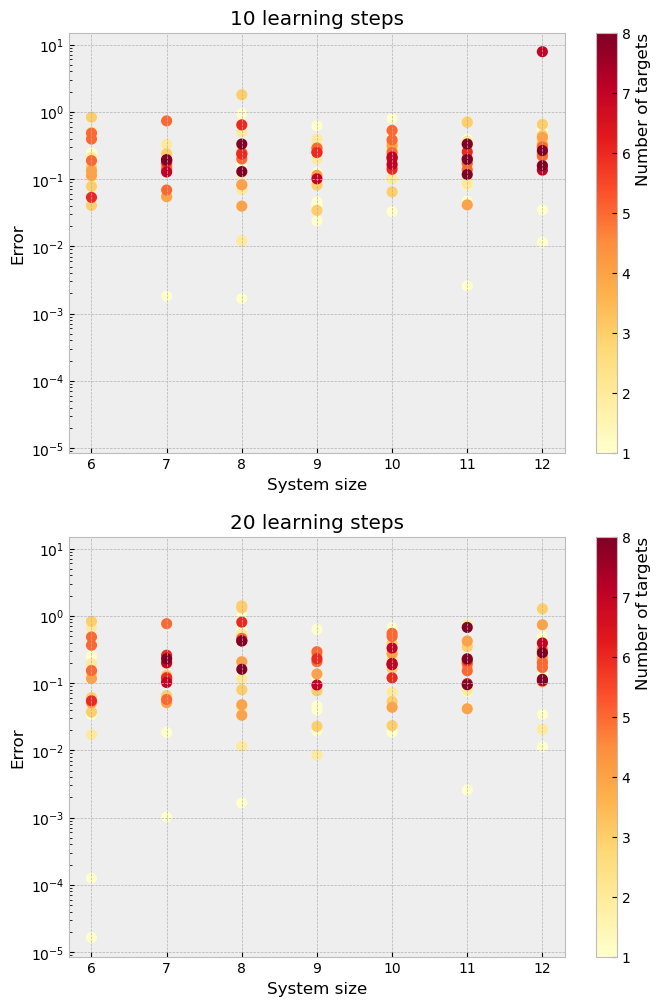

In [166]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,12))

sc = ax1.scatter(data_accepted['System size'], data_accepted['Error (10 steps)'], c=data_accepted['Number of targets'],  linewidths=2.0, cmap='YlOrRd')
ax1.set_xlabel('System size')
ax1.set_ylabel('Error')
ax1.set_yscale("log")
ax1.set_title("10 learning steps")
cbar = fig.colorbar(sc)
cbar.set_label("Number of targets", loc='top')

sc = ax2.scatter(data_accepted['System size'], data_accepted['Error (20 steps)'], c=data_accepted['Number of targets'],  linewidths=2.0, cmap='YlOrRd')
ax2.set_xlabel('System size')
ax2.set_ylabel('Error')
ax2.set_yscale("log")
ax2.set_title("20 learning steps")
cbar = fig.colorbar(sc)
cbar.set_label("Number of targets", loc='top')

In [167]:
data.to_csv('data_unsorted.csv')
data_accepted.to_csv('data_accepted.csv')
data_rejected.to_csv('data_rejected.csv')

: 